In [46]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import glob
import importlib

In [47]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [48]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [49]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

### **Set up files and genes for inference**

In [50]:
#Threshold for filtering 
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [51]:
#Looms, transcriptomes and (technical) sampling params

looms = ['/home/tchari/counts/breast_cancer_mm/brca1/loom/processed_brca1_raw.loom',
        '/home/tchari/counts/10x_pbmcs/loom/processed_pbmc_10k_raw.loom',
        '/home/tchari/counts/germcell_splicing/loom/processed_E11E13_raw.loom']

transcrips = ['/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1',
             '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',
             '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1']

datas = ['brca1','pbmc','e11e13']
attribute_names =[('unspliced','spliced'),'gene_name','barcode']

tech_params = [[-6.777777777777778, -0.6999999999999997],
               [-5.666666666666666, -0.6999999999999997],
               [-6.777777777777778, -1.25]]

In [52]:
#List of Ks for each loom 
ks = [[5,10,15],[3,10,15],[2,5,10]]

In [53]:
#Genes for PBMCS
all_marks = pd.read_csv('/home/tchari/metadata/all_pbmc_markers.csv')
print(all_marks.head())

#From lit + https://satijalab.org/seurat/articles/pbmc3k_tutorial.html
toplot_marks = ['CD300E','FCGR2B','CD40',
                'CD69','MS4A1','CD79A','PTPRC',
                'CD3D','IL7R','LEF1','TRAC','CD4','CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3','CD28','IRF4','CCR6','GATA3','IL2RA','FOXP1','CD38',
               'CX3CR1','CD86','ADGRE1'] + ['CD14','FCGR3A','FCGR3B','CCR2','CCR5','CCR7',
'CD69','ITGAE','CTLA4','NCAM1','FOXP3','STAT4', 'TCF7','IL26',
'IL22','IL13','KLRB1','CXCR3','CD38',
'CLEC9A','ITGAX','XCR1','CD1C','CD207','ITGAM', 'NOTCH2',
'BATF3','CCR7','CD8A','CD8B',
'BCL2','BCL6','CD5','CD27','CD79B','SDC1','TLR9','XBP1','GZMB','IL3RA','CD74',
'IL7R', 'CCR7','LYZ','S100A4','GNLY', 'NKG7','FCER1A', 'CST3','PPBP','PF4'] 

pbmc_markers = list(all_marks['gene_name']) + toplot_marks #Added

pbmc_markers = list(np.unique(pbmc_markers)) #Added

  gene_name  num_cell_types
0     PTPRC              28
1      CD14              27
2     IL-7R              24
3      CD3D              24
4    FCG3RA              23


In [120]:
germ_markers = np.unique(['Bnc2', 'Dmrt1', 'Tet1', 'Ccnd3','Tbrg4', 'Rbm38', 
           'Supt6','Nanos2', 'Dnmt3l' ,'Piwil4', 'Pou5f1',
           'Stra8', 'Rec8','Nanog','Lefty1', 'Lefty2','Pycr2',
          'Id1','Bmp2','Fst','Inhbb','Grem2',
          'Cdx2','Gata2','Msx1','Msx2','Zfp42','Lhx1',
          'Stra8', 'Sycp1', 'Sycp3', 'Sync3', 'Spo11', 'Ccdc155', 'Dmc1', 'Mei1',
           'Mei4', 'Meioc', 'Hormad1', 'Hormad2', 'Msh5', 'Tex11', 'Prdm9', 'Zglp1', 'Smc1b',
          'Pitx2','Otx2','Gata2', 'Id1', 'Id2', 'Id3', 'Cdx2', 'Smad6', 'Dlx3', 'Msx1', 'Msx2',
            'Gata2' ,'Nr3c1','Kdm5a','Pbx3','Phf8','Lef1','Cdx2','Hcfc1','Eomes','E2f5',
            'Hdac2','Nr2c1','Rela','Maz','Atf4','Jun','Otx2','Egr4','Myc','Bcas2'])

BRCA1-null cells had increased expression of basal-associated genes such as Krt14, Vim and Sparc (Figure 1D–E). Intriguingly, the BRCA1-null tumor cells could be segregated further into cells with basal (Cluster 4) and mesenchymal (Cluster 5) features, respectively (Figure 1D). Cluster 4 cells expressed higher levels of epithelial genes (Cldn4, Cldn3, Epcam) whereas Cluster 5 was defined by expression of mesenchymal genes (Vim, Sparc, Col3a1, Bgn)

The BRCA1-1 cluster consisted of proliferating cells with increased expression of cell cycle related genes such as Birc5, Tyms and Mki67. BRCA1-5 was a cluster with strongest expression of prototypical basal genes such as Krt14 and Igfbp5. Interestingly, BRCA1-2 cells exhibited a partial EMT gene expression pattern with moderate levels of collagens and the highest levels of EMT transcription factors such as Yap1, Twist1 and Zeb1 (Figure 4B). On the other hand, BRCA1-3 cells expressed the highest levels of genes associated with fibroblasts (Figure 4B) and this would fit with our previous observations of a sub-population of BRCA1 null cells with mesenchymal characteristics (Figures 1–3). Within this predominantly basal tumor type, cells with features of AvPs (BRCA1-4) were also present with elevated levels of Cldn3, Malat1, Krt18, Wfdc18 and Mfge8. Once again, the extensive heterogeneity within these BRCA1-null tumors were apparent along with the genes and pathways for each of these clusters (Figure 4—source datas 1–2).

While the association between proliferation (cluster BRCA1-1) and poor prognosis may not be too surprising (van Diest et al., 2004), the observation that alveolar progenitor-like (cluster BRCA1-4) gene expression was associated with poorer survival is interesting and worthy of further examination in future work. Since CD14 protein expression can be detected in a subset of BRCA1-null mouse tumor cells (Figure 5—figure supplement 1A), as well as human breast cancers

In [55]:
#also from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6800274/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10132032/
brca_markers = np.unique(['Krt14', 'Vim','Sparc',
                         'Cldn4', 'Cldn3', 'Epcam',
                         'Vim', 'Sparc', 'Col3a1', 'Bgn',
                         'Birc5', 'Tyms','Mki67',
                         'Krt14','Igfbp5','Yap1', 'Twist1',
                          'Zeb1','Cldn3', 'Malat1', 'Krt18', 
                          'Wfdc18','Mfge8',
                         'Rbfox2','Sf3b1','Srsf2','U2af1',
                         'Zrsf2',' Srsf1', 'Srsf2', 'Srsf3','U2af65',
                         'Pkm1','Pkm2','Ilf3','Qki','Rbm5',
                         'Hipk2','Bin1', 'Bim','Bcl2l11','Mcl1', 'Casc4',
                         'Ron', 'Mknk2', 'S6k1', 'Casc4', 'Prrc2c',
                         'Casp8','Fas','Fbln2','Mcl1','Bcl2l1','Bcl2l11','Bin1','Casp2',
                        'Pkm','Hif1a','Numb','Ezh2','Map2k7','Her2','Mdm2','Gap17','Egfr',
                        'Birc5','Ccnd1','Hras','Mknk2','Rps6kb1','Klf6','Pten','Il1rap','Cd19','Cd47',
                        'Tert','Cd45','Il7','Fn1','Cd44','Ceacam1','Enah','Mstr1','Tnc','Fgfr2','Vegfa','Irf3',
                        'Exoc7','Kat5','Tip60','Brca1',
                         'Esrp1','Esrp2','Hnrnpa1','Hnrnpi','Hnrnpm','Rbm6','Rbm10','Srsf1','Srsf3',
                          'Srsf4','Srsf5','Srsf6','Tra2b'])

**Go through looms and select genes that include lists above**

In [56]:
all_markers = [brca_markers,pbmc_markers,germ_markers]

### **Fit meK-Means for range of Ks**

**Make files for meK-Means runs and select genes**

In [124]:
!mkdir /home/tchari/perturbCME/notebooks/fits/explorData_0313


dir_strings = []
data_strings = []
result_strings = []

for loom,transc,data_name,g_lit,tech_tup,Ks in zip(looms,transcrips,datas,all_markers,tech_params,ks):
    
    ds = lp.connect(loom)
    g_names = ds.ra[attribute_names[1]]
    num_genes = len(g_names)
    num_cells = len(ds.ca[attribute_names[2]])
    
    U = ds.layers['unspliced'][:,:].T
    S = ds.layers['spliced'][:,:].T
    if data_name == 'e11e13':
        true_labs = list(ds.ca['subclass_label'])
    ds.close()
    
    
    g_filt = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
    g_filt_lit = pd.Categorical(g_names).isin(g_lit)
    
    if 'pbmc' not in data_name:
        adata = anndata.AnnData(X=S)
        adata.layers["counts"] = adata.X.copy()  # preserve counts
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.raw = adata
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        g_filt_hvg = adata.var.highly_variable
    else:
        g_filt_hvg = g_filt_lit #Just using lit genes here
        g_filt_lit = g_filt_lit & g_filt
        
    final_filt = (g_filt_lit) | (g_filt_hvg & g_filt) #Filter hvgs + add lit genes
    final_names = g_names[final_filt]
    
    print(data_name+' with '+str(len(final_names))+' genes')
    print('Num lit genes used: ',np.sum(g_filt_lit)) #&g_filt
    
    #------- Run meK-Means ----------
    #Define bounds for params
    phys_lb = [-3.0, -3, -3 ] 
    phys_ub = [4.2, 2.5, 2.5] 
    samp_lb = tech_tup 
    samp_ub = tech_tup  
    gridsize = [1,1] #Already have tech params


    epochs = 10

    for clus in Ks:
        #Set up files for Monod
        dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/explorData_0313',\
                                                 meta=data_name+'_K'+str(clus),batch_id=1,\
                                                 n_genes=len(final_names),exp_filter_threshold=None,
                                                 viz=False,genes_to_fit=final_names)
        dir_strings += [dir_string]
        data_strings += [dataset_string]
    
        # ---------------- meK-Means Inference ---------------- 
        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_string[0],fitmodel,k=clus,epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(loom, transc, data_name,
                    dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names)

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

        result_strings.append(full_result_string)
        print('Result: ',full_result_string)


        # ----------------  Save output ---------------- 
        #Read in results and get cluster assignments
        sr = [monod.analysis.load_search_results(i) for i in full_result_string]


        cat_assigns = np.array([None]*num_cells) #cat_assigns is empty list of length = no. cell barcodes
        for i in range(len(sr)):
            r = sr[i]
            cat_assigns[r.filt] = r.assigns #denotes which cluster (k), cells were assigned to

        print('No. clus: ',len(np.unique(cat_assigns)))


        if data_name == 'e11e13':
            print('ARI: ',adjusted_rand_score(true_labs,cat_assigns))
            


mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/explorData_0313’: File exists


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


brca1 with 339 genes
Num lit genes used:  77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.48s/it]


mstep self.weights:  [0.11572588 0.32452263 0.11271697 0.15698461 0.2900499 ]
Q Function:  -1049397.882514434



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.75s/it]


mstep self.weights:  [0.08259088 0.2869328  0.10572294 0.21901899 0.3057344 ]
Q Function:  -1066712.7718592482



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.63s/it]


mstep self.weights:  [0.0887158  0.25453188 0.09205458 0.25445222 0.31024551]
Q Function:  -1128809.7454877577



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.13s/it]


mstep self.weights:  [0.06010224 0.21516188 0.02018601 0.2675593  0.43699057]
Q Function:  -1082029.4145981807



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.11s/it]


mstep self.weights:  [7.81441631e-03 1.61388468e-01 3.55871885e-10 3.02441887e-01
 5.28355228e-01]
Q Function:  -1087554.9722782



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.61s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 3.55871885e-10 5.68117259e-01
 4.31882740e-01]
Q Function:  -1081260.4970810646



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.97s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 3.55871885e-10 5.95167772e-01
 4.04832227e-01]
Q Function:  -1062782.3386078156



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.66s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 3.55871885e-10 5.45543273e-01
 4.54456726e-01]
Q Function:  -1086333.0291747563



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.28s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 3.55871885e-10 5.74440545e-01
 4.25559454e-01]
Q Function:  -1074445.69256646



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.94s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 3.55871885e-10 5.34108464e-01
 4.65891535e-01]
Q Function:  -1088519.9987977515

Result:  ['./fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorData_0313/gg_240312_025_brca1_K5_1/brca1/Bursty_Poisson_1x1/grid_scan_results_4.res']
No. clus:  2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


mstep self.weights:  [0.08399188 0.00388138 0.28552442 0.24827477 0.09823684 0.00368032
 0.00210034 0.20189999 0.03966895 0.03274111]
Q Function:  -1109824.7750045673



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.36s/it]


mstep self.weights:  [5.02991670e-02 3.55871885e-10 4.17059770e-01 2.78764207e-01
 2.23361793e-02 3.55871885e-10 3.55871885e-10 2.12498139e-01
 1.56490273e-02 3.39350860e-03]
Q Function:  -1072282.0387054628



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.13s/it]


mstep self.weights:  [1.62660899e-03 3.55871885e-10 4.26525444e-01 3.18687614e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.53160331e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1069563.074530967



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.55s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 4.19668939e-01 3.17880954e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.62450104e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1065266.73317328



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.98s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 4.36571049e-01 2.95267002e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.68161947e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1079820.6777590094



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.68s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 4.61909108e-01 2.76036306e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.62054583e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1046545.5553898074



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.51s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 5.15806962e-01 2.57794268e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.26398767e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1084097.7157014299



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.37s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 5.19896183e-01 2.51483624e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.28620191e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1058374.284925304



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.12s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 5.04394588e-01 2.69380300e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 2.26225109e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1047291.8520470054



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.99s/it]


mstep self.weights:  [3.55871885e-10 3.55871885e-10 5.83438190e-01 2.27724471e-01
 3.55871885e-10 3.55871885e-10 3.55871885e-10 1.88837336e-01
 3.55871885e-10 3.55871885e-10]
Q Function:  -1101930.8641006732

Result:  ['./fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_2.res', './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorData_0313/gg_240312_025_brca1_K10_1/brca1/Bursty_Poisson_1x1/grid_scan_results_7.res']
No. clus:  3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.59s/it]


mstep self.weights:  [1.73952711e-01 1.72083219e-01 5.86701905e-03 5.77937249e-03
 1.62923980e-02 2.66430791e-03 5.47122572e-02 2.43492032e-02
 3.86858250e-01 1.05012819e-02 1.08389180e-01 4.22641515e-03
 7.04116561e-03 8.97202219e-06 2.72742476e-02]
Q Function:  -1124656.9809104237



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


mstep self.weights:  [2.29913165e-01 2.76000634e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 1.65176149e-02 3.55871897e-10
 3.64477650e-01 3.55871884e-10 1.12968055e-01 3.55871884e-10
 3.55871884e-10 1.22877839e-04 3.55871884e-10]
Q Function:  -1085265.1135373877



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.95s/it]


mstep self.weights:  [4.08945474e-01 2.20832117e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 1.35049568e-09
 3.69540266e-01 3.55871884e-10 3.24016594e-06 3.55871884e-10
 3.55871884e-10 6.78898379e-04 3.55871884e-10]
Q Function:  -1048878.379367216



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.35s/it]


mstep self.weights:  [4.14950536e-01 2.46161535e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.38887924e-01 3.55871884e-10 8.41586908e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1074861.8933399317



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.39s/it]


mstep self.weights:  [3.91222102e-01 2.46483902e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.62293991e-01 3.55871884e-10 3.56042000e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1071965.243611306



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.08s/it]


mstep self.weights:  [3.62121423e-01 2.46907105e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.90971467e-01 3.55871884e-10 3.56863636e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1066909.0555216307



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.41s/it]


mstep self.weights:  [3.65775958e-01 2.58468653e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.75755375e-01 3.55871884e-10 9.98668846e-09 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1078428.0333584172



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.51s/it]


mstep self.weights:  [3.81380255e-01 2.65294494e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.53325246e-01 3.55871884e-10 3.86200006e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1069074.9773087113



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.96s/it]


mstep self.weights:  [3.73147212e-01 2.66330230e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.60522554e-01 3.55871884e-10 3.56682776e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1062943.3981231567



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.37s/it]


mstep self.weights:  [3.82909223e-01 2.68932721e-01 3.55871884e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10 3.55871884e-10
 3.48158051e-01 3.55871884e-10 3.56254539e-10 3.55871884e-10
 3.55871884e-10 3.55871884e-10 3.55871884e-10]
Q Function:  -1069061.3283213035

Result:  ['./fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_1.res', './fits/explorData_0313/gg_240312_025_brca1_K15_1/brca1/Bursty_Poisson_1x1/grid_scan_results_8.res']
No. clus:  3


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


pbmc with 793 genes
Num lit genes used:  793


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:04<00:00, 21.40s/it]


mstep self.weights:  [0.50007226 0.34109772 0.15883002]
Q Function:  -10915926.615051633



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.69s/it]


mstep self.weights:  [0.50151565 0.34271534 0.155769  ]
Q Function:  -10732165.799103064



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.86s/it]


mstep self.weights:  [0.50311231 0.34372889 0.15315881]
Q Function:  -10739009.475584673



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.30s/it]


mstep self.weights:  [0.50368659 0.34362872 0.15268469]
Q Function:  -10728087.529519554



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.01s/it]


mstep self.weights:  [0.50384256 0.34369252 0.15246492]
Q Function:  -10728006.437687399



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.87s/it]


mstep self.weights:  [0.50397017 0.34376709 0.15226274]
Q Function:  -10728323.941954235



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.22s/it]


mstep self.weights:  [0.50401825 0.34390647 0.15207528]
Q Function:  -10728017.690833839



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:04<00:00, 21.58s/it]


mstep self.weights:  [0.5041679  0.34390178 0.15193032]
Q Function:  -10728078.086723872



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.69s/it]


mstep self.weights:  [0.50404202 0.34396706 0.15199092]
Q Function:  -10728690.5120326



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.21s/it]


mstep self.weights:  [0.50404197 0.34396709 0.15199094]
Q Function:  -10728690.511941757

Result:  ['./fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_1.res', './fits/explorData_0313/gg_240312_025_pbmc_K3_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_2.res']
No. clus:  3


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.51s/it]


mstep self.weights:  [0.11503533 0.21608088 0.0825887  0.13915496 0.01396563 0.00840334
 0.05529356 0.2541869  0.01452408 0.10076661]
Q Function:  -11068650.994728804



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]


mstep self.weights:  [0.1315838  0.20603053 0.09054554 0.13745916 0.00148255 0.01846226
 0.05716644 0.23798977 0.01747914 0.10180081]
Q Function:  -10518275.393401204



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:02<00:00,  7.00s/it]


mstep self.weights:  [1.54929282e-01 1.82217747e-01 8.81216825e-02 1.36520672e-01
 8.66851594e-11 2.54151803e-02 5.41883708e-02 2.32759253e-01
 1.90701735e-02 1.06777637e-01]
Q Function:  -10474436.741845667



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.06s/it]


mstep self.weights:  [1.58580811e-01 1.87890652e-01 9.01404503e-02 1.35935222e-01
 8.66851594e-11 2.84991445e-02 5.13484440e-02 2.27070769e-01
 2.03344731e-02 1.00200035e-01]
Q Function:  -10461906.071514713



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.10s/it]


mstep self.weights:  [1.76201669e-01 1.67492751e-01 9.29766542e-02 1.34137768e-01
 8.66851594e-11 2.94361096e-02 5.07026729e-02 2.22933430e-01
 2.28323241e-02 1.03286621e-01]
Q Function:  -10458066.750595974



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.22s/it]


mstep self.weights:  [2.66491552e-01 6.73921630e-02 9.46194577e-02 1.33013978e-01
 8.66851594e-11 3.04283803e-02 4.61233060e-02 2.20060665e-01
 2.54340311e-02 1.16436467e-01]
Q Function:  -10490277.778595433



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.08s/it]


mstep self.weights:  [3.02224699e-01 3.50681013e-02 9.48387605e-02 1.31380115e-01
 8.66851594e-11 3.15592284e-02 4.79849464e-02 2.17903069e-01
 2.77647092e-02 1.11276372e-01]
Q Function:  -10443972.366335742



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.09s/it]


mstep self.weights:  [3.12707812e-01 2.22014070e-02 9.52260918e-02 1.30359809e-01
 8.66851594e-11 3.19526624e-02 4.68052394e-02 2.17044436e-01
 2.97993320e-02 1.13903211e-01]
Q Function:  -10451452.316090386



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.09s/it]


mstep self.weights:  [3.15412108e-01 7.26457471e-03 9.59158427e-02 1.30333222e-01
 8.66851594e-11 3.19932837e-02 4.48468009e-02 2.16916340e-01
 3.14499322e-02 1.25867896e-01]
Q Function:  -10481420.162341325



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:05<00:00,  8.25s/it]


mstep self.weights:  [3.11607839e-01 8.66851594e-11 9.60335549e-02 1.29139592e-01
 8.66851594e-11 3.19958976e-02 4.69902303e-02 2.16892059e-01
 3.26368357e-02 1.34703991e-01]
Q Function:  -10479465.427389137

Result:  ['./fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_2.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_5.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_6.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_7.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_8.res', './fits/explorData_0313/gg_240312_025_pbmc_K10_1/pbmc/Bursty_Poisson_1x1/grid_scan_resul

/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:02<00:00,  4.18s/it]


mstep self.weights:  [0.01056674 0.00237505 0.02052208 0.0908785  0.01058954 0.00867563
 0.16652547 0.14921197 0.05142008 0.00827994 0.00338908 0.27336949
 0.13153853 0.00028172 0.07237618]
Q Function:  -11334447.265756946



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.82s/it]


mstep self.weights:  [9.57893960e-03 8.66851692e-04 1.21428505e-02 9.91090955e-02
 2.18087030e-02 6.13342460e-03 1.69118816e-01 1.42913226e-01
 5.28598670e-02 8.66851594e-11 6.04438093e-03 2.75122058e-01
 1.33275987e-01 1.92578523e-08 7.10257804e-02]
Q Function:  -10465166.083501413



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:02<00:00,  5.18s/it]


mstep self.weights:  [7.54429869e-03 8.66851594e-11 1.14365281e-04 1.07270865e-01
 2.67096990e-02 7.89703953e-03 1.69831485e-01 1.46201884e-01
 5.04833000e-02 8.66851594e-11 1.00027844e-02 2.69780598e-01
 1.31663948e-01 8.66851594e-11 7.24997326e-02]
Q Function:  -10444443.047260545



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:02<00:00,  5.71s/it]


mstep self.weights:  [6.93481341e-03 8.66851594e-11 8.66851594e-11 9.90492788e-02
 2.83905359e-02 9.88711780e-03 1.48943756e-01 1.64588577e-01
 5.14854266e-02 8.66851594e-11 1.14541687e-02 2.43515408e-01
 1.30277754e-01 8.66851594e-11 1.05473163e-01]
Q Function:  -10447419.440204289



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.74s/it]


mstep self.weights:  [6.84812856e-03 8.66851594e-11 8.66851594e-11 9.92962771e-02
 2.90256333e-02 1.07051778e-02 1.41887313e-01 1.69894198e-01
 5.10468908e-02 8.66851594e-11 1.35572342e-02 1.92278173e-01
 1.29746491e-01 8.66851594e-11 1.55714482e-01]
Q Function:  -10396863.619595446



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.80s/it]


mstep self.weights:  [6.84812975e-03 8.66851594e-11 8.66851594e-11 1.02838161e-01
 2.97318550e-02 1.10035064e-02 1.31270202e-01 1.77375398e-01
 4.71142837e-02 8.66851594e-11 1.57984265e-02 1.87721695e-01
 1.29361492e-01 8.66851594e-11 1.60936849e-01]
Q Function:  -10408761.191337911



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:03<00:00,  5.76s/it]


mstep self.weights:  [6.84818805e-03 8.66851594e-11 8.66851594e-11 1.01979006e-01
 3.08696269e-02 1.11285152e-02 1.24738957e-01 1.80579858e-01
 4.78480755e-02 8.66851594e-11 1.79241930e-02 1.83996931e-01
 1.29233165e-01 8.66851594e-11 1.64853485e-01]
Q Function:  -10388370.538066313



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:06<00:00,  6.07s/it]


mstep self.weights:  [6.84812780e-03 8.66851594e-11 8.66851594e-11 1.01902571e-01
 3.20391795e-02 1.16436423e-02 1.20942815e-01 1.81805710e-01
 4.81541983e-02 8.66851594e-11 1.90306699e-02 1.79957899e-01
 1.29117608e-01 8.66851594e-11 1.68557579e-01]
Q Function:  -10384302.217520593



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:05<00:00,  5.91s/it]


mstep self.weights:  [6.88897074e-03 8.66851594e-11 8.66851594e-11 1.02210747e-01
 3.19934652e-02 1.19454381e-02 1.18048462e-01 1.83944881e-01
 4.85239461e-02 8.66851594e-11 1.97400826e-02 1.73590560e-01
 1.28975925e-01 8.66851594e-11 1.74137521e-01]
Q Function:  -10388247.958830362



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:06<00:00,  6.06s/it]


mstep self.weights:  [6.84814089e-03 8.66851594e-11 8.66851594e-11 1.02018965e-01
 3.21560660e-02 1.18597224e-02 1.14846954e-01 1.85352176e-01
 4.87199649e-02 8.66851594e-11 2.14073421e-02 1.69816453e-01
 1.29051256e-01 8.66851594e-11 1.77922959e-01]
Q Function:  -10388558.468786031

Result:  ['./fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_4.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_5.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_6.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_7.res', './fits/explorData_0313/gg_240312_025_pbmc_K15_1/pbmc/Bursty_Poisson_1x1/grid_scan_results_8.res', './fits/expl

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


e11e13 with 268 genes
Num lit genes used:  54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.12s/it]


mstep self.weights:  [0.614823 0.385177]
Q Function:  -887130.0427858704



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.83s/it]


mstep self.weights:  [0.34622125 0.65377875]
Q Function:  -872146.2659203226



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.55s/it]


mstep self.weights:  [0.23394313 0.76605687]
Q Function:  -858448.339399063



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.58s/it]


mstep self.weights:  [0.17595245 0.82404755]
Q Function:  -866889.022236031



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.92s/it]


mstep self.weights:  [0.18001708 0.81998292]
Q Function:  -896027.99294375



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.56s/it]


mstep self.weights:  [0.19104835 0.80895165]
Q Function:  -894161.221759257



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.06s/it]


mstep self.weights:  [0.18751742 0.81248258]
Q Function:  -899789.5176344279



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.46s/it]


mstep self.weights:  [0.18367689 0.81632311]
Q Function:  -897672.545263771



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.59s/it]


mstep self.weights:  [0.18305347 0.81694653]
Q Function:  -897051.5390738327



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.99s/it]


mstep self.weights:  [0.17902602 0.82097398]
Q Function:  -893799.9784006092

Result:  ['./fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_1.res']
No. clus:  2
ARI:  0.5003667795236505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]


mstep self.weights:  [0.43885698 0.10302174 0.10914686 0.06507334 0.28390107]
Q Function:  -870724.8999272098



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.04s/it]


mstep self.weights:  [0.16701347 0.07750946 0.07039026 0.06355114 0.62153566]
Q Function:  -861854.3486298048



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


mstep self.weights:  [0.19465378 0.07691917 0.0021169  0.06340806 0.66290209]
Q Function:  -884485.9303783374



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it]


mstep self.weights:  [1.00570673e-01 7.27748573e-02 4.05844155e-10 6.33532740e-02
 7.63301196e-01]
Q Function:  -882398.3850418779



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.47s/it]


mstep self.weights:  [6.97304982e-02 5.64799959e-02 4.05844155e-10 6.16407704e-02
 8.12148735e-01]
Q Function:  -853088.3180318163



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.74s/it]


mstep self.weights:  [9.63073447e-02 5.03070254e-02 4.05844155e-10 6.20935227e-02
 7.91292107e-01]
Q Function:  -892714.4731618024



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.84s/it]


mstep self.weights:  [7.38429583e-02 6.17347154e-02 4.05844155e-10 6.23931518e-02
 8.02029174e-01]
Q Function:  -877334.0932428977



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.52s/it]


mstep self.weights:  [7.07293188e-02 5.73746499e-02 4.05844155e-10 6.20950330e-02
 8.09800998e-01]
Q Function:  -891227.7631889309



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.51s/it]


mstep self.weights:  [5.19833738e-02 4.90741218e-02 4.05844155e-10 6.17707127e-02
 8.37171791e-01]
Q Function:  -860267.3068212043



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.59s/it]


mstep self.weights:  [3.10581290e-02 4.74311120e-02 4.05844155e-10 6.24554905e-02
 8.59055268e-01]
Q Function:  -861091.8811702454

Result:  ['./fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_1.res', './fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_3.res', './fits/explorData_0313/gg_240312_025_e11e13_K5_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_4.res']
No. clus:  4
ARI:  0.40303289058242703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


mstep self.weights:  [0.08475542 0.31867194 0.16900202 0.00670754 0.14556841 0.00466558
 0.13854413 0.05267613 0.07617751 0.00323134]
Q Function:  -883723.0718661816



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]


mstep self.weights:  [3.18191757e-01 2.20806114e-01 8.92084302e-02 4.05844154e-10
 2.71767526e-01 4.05844154e-10 3.30508897e-02 5.85018025e-02
 8.47347959e-03 4.05844154e-10]
Q Function:  -872140.3715122751



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


mstep self.weights:  [3.84217746e-01 1.64550346e-01 6.06493707e-02 4.05844154e-10
 3.28070640e-01 4.05844154e-10 4.16189419e-10 6.25118953e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -872828.7606924552



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.14s/it]


mstep self.weights:  [2.64448216e-01 3.57259061e-01 4.41072798e-02 4.05844154e-10
 2.71278924e-01 4.05844154e-10 4.05844164e-10 6.29065176e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -865835.7736638677



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


mstep self.weights:  [3.72210860e-01 3.05132555e-01 3.96372938e-03 4.05844154e-10
 2.56027681e-01 4.05844154e-10 4.05844154e-10 6.26651730e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -867205.8821752707



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]


mstep self.weights:  [2.70679573e-01 4.45284896e-01 4.05844154e-10 4.05844154e-10
 2.21601254e-01 4.05844154e-10 4.05844154e-10 6.24342750e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -842292.2340865164



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.61s/it]


mstep self.weights:  [2.31336944e-01 4.48685223e-01 4.05844154e-10 4.05844154e-10
 2.57427055e-01 4.05844154e-10 4.05844294e-10 6.25507755e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -868737.6690574993



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.55s/it]


mstep self.weights:  [1.91128562e-01 3.01408986e-01 4.05844154e-10 4.05844154e-10
 4.43347543e-01 4.05844154e-10 4.05844155e-10 6.41149067e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -860094.6772867875



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.90s/it]


mstep self.weights:  [1.26285909e-01 1.29670949e-01 4.05844154e-10 4.05844154e-10
 6.79519907e-01 4.05844154e-10 4.05844562e-10 6.45232332e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -849865.6581571323



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.62s/it]


mstep self.weights:  [9.66788507e-02 1.07858696e-01 4.05844154e-10 4.05844154e-10
 7.30971644e-01 4.05844154e-10 4.05844154e-10 6.44908068e-02
 4.05844154e-10 4.05844154e-10]
Q Function:  -874634.4890391048

Result:  ['./fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_1.res', './fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_4.res', './fits/explorData_0313/gg_240312_025_e11e13_K10_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_7.res']
No. clus:  4
ARI:  0.33007503960409307


**Run meK-Means**

In [138]:
full_result_string = ['./fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_0.res', './fits/explorData_0313/gg_240312_025_e11e13_K2_1/e11e13/Bursty_Poisson_1x1/grid_scan_results_1.res']
sr = [monod.analysis.load_search_results(i) for i in full_result_string]


cat_assigns = np.array([None]*num_cells) #cat_assigns is empty list of length = no. cell barcodes
for i in range(len(sr)):
    r = sr[i]
    cat_assigns[r.filt] = r.assigns

In [139]:
uniqs = np.unique(cat_assigns)
for i in uniqs:
    filt = cat_assigns == i
    print(i)
    print(np.sum(np.array(true_labs)[filt] == '170726_T_E13'))
    print(np.sum(np.array(true_labs)[filt] == '170814_AGPM_E11'))
    print('------------')

0
236
207
------------
1
2010
11
------------


In [127]:
'Srsf10' in final_names  #Ccnd3, Bnc2m, Tet1, and 

False

In [128]:
[g for g in germ_markers if g in final_names ]

['Bcas2',
 'Bmp2',
 'Bnc2',
 'Ccdc155',
 'Ccnd3',
 'Cdx2',
 'Dlx3',
 'Dmrt1',
 'Dnmt3l',
 'E2f5',
 'Egr4',
 'Eomes',
 'Gata2',
 'Grem2',
 'Hcfc1',
 'Hdac2',
 'Hormad1',
 'Hormad2',
 'Id1',
 'Id2',
 'Id3',
 'Inhbb',
 'Jun',
 'Kdm5a',
 'Lef1',
 'Lefty1',
 'Lefty2',
 'Lhx1',
 'Maz',
 'Mei4',
 'Meioc',
 'Msh5',
 'Msx1',
 'Msx2',
 'Myc',
 'Nanog',
 'Nanos2',
 'Nr2c1',
 'Pbx3',
 'Phf8',
 'Pitx2',
 'Piwil4',
 'Pou5f1',
 'Pycr2',
 'Rbm38',
 'Smad6',
 'Spo11',
 'Stra8',
 'Supt6',
 'Sycp1',
 'Sycp3',
 'Tbrg4',
 'Tex11',
 'Zfp42']

In [134]:
g_test = 'Nanog'

(array([1.01809344e+00, 3.01782339e-01, 8.16905212e-02, 0.00000000e+00,
        1.82284634e-02, 6.07615447e-03, 0.00000000e+00, 1.35025655e-03,
        6.75128274e-04, 6.75128274e-04]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

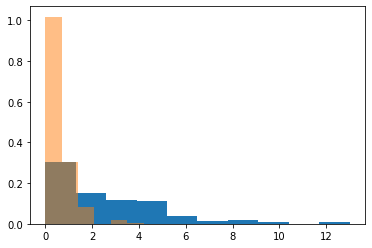

In [135]:
plt.hist(S[cat_assigns==1,g_names==g_test].flatten(),density=True)
plt.hist(S[cat_assigns==4,g_names==g_test].flatten(),density=True,alpha=0.5)

In [136]:
np.mean(S[cat_assigns==1,g_names==g_test])

2.547008547008547

In [137]:
np.mean(S[cat_assigns==4,g_names==g_test])

0.39177693761814747